# Imports + paramètres

- imports
- pattern_size, square_size
- chemins data/chessboards, data/scanLeft, data/scanRight
- plt.rcParams...

---

- On utilise openCV car cela fournit tous les outils de vision par ordinateur nécessaires à la calibration et à la stéréovion.

- import numpy as np : est utilisé pour la manipulation mathématiques des matrices et des points homogènes.

- import matplotlib.pyplot as plt : me permet de visualiser les résultats pour vérifier la cohérence géométrique

- from pathlib import Path: j'utilise pour gérer les chemins de fichiers de manière propre et portable

- import glob : me permet de charger automatiquement toutes les images de calibration

- plt.rcParams["figure.figsize"] = (12, 7) : je definis une taille d'affichage standard pour que les résultats soient lisibles notamment pour les lignes épipolaires.

- PATTERN_SIZE = (7, 7): il correspond au nombre de coins internes du damier, tel que requis par OpenCV.

- SQUARE_SIZE = 1.0 : la taille du carreau fixe l'échelle du monde 3D, ici j'utilise une unité arbitraire car seules les proportions importent.

- CB_DIR = Path("data/chessboards"): ce dossier contient les images utilisées pour la calibration mono et stéréo

- SCAN_LEFT_DIR = "data/scanLeft/*.png" et SCAN_RIGHT_DIR = "data/scanRight/*.png" : les images de scan sont utilisées après calibration pour la reconstruciton 3D.

- REF_LEFT = CB_DIR / "c4Left.png" et REF_RIGHT = CB_DIR / "c4Right.png" : j'utilise une paire de référence stable pour illustrer la géométrie épipolaire et éviter les variations entre images.





In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

plt.rcParams["figure.figsize"] = (12, 7) # (10,6)

# paramètres globaux

pattern_size = (7, 7)      # coins internes du damier
square_size = 1.0          # taille carreau (unité arbitraire)

CB_DIR = Path("data/chessboards")
SCAN_LEFT_DIR = "data/scanLeft/*.png"
SCAN_RIGHT_DIR = "data/scanRight/*.png"

# Paire de référence pour F et P1/P2 (choisis c4 si stable)
REF_LEFT = CB_DIR / "c4Left.png"
REF_RIGHT = CB_DIR / "c4Right.png"

# Détection des coins

je commence par vérifier que les coins du damier sont bien détectées, sinon la calibration est impossible.
Ensuite je raffine les coins en sub-pixel pour améliorer la précision.

In [150]:
def detect_chessboard_corners(img_path, pattern_size):
    """
    cette fonction detecte les coins internes du damier dans l'imafe et améliore leur precision.
    grace à un raffinement subpixel. les coins retournes au format attendu par openCV pour la calibration.
    - findChessboardCorners detecte les coins initiaux.
    - cornerSubPix améliore la précision des coins détectés
    - drawChessboardCorners dessine les coins détectés sur l'image pour visualisation.
    Retour:
        - success (bool)
        - corners (N,1,2) float32 (format OpenCV)
        - img_draw (H,W,3) uint8: image avec coins dessinés
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Image introuvable: {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    ok, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    # Fallback SB si standard échoue
    if not ok and hasattr(cv2, "findChessboardCornersSB"):
        ok, cornersSB = cv2.findChessboardCornersSB(gray, pattern_size)
        if ok:
            corners = cornersSB.reshape(-1, 1, 2).astype(np.float32)

    if not ok:
        return False, None, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    corners = cv2.cornerSubPix(gray, corners.astype(np.float32),
                               (11, 11), (-1, -1), criteria)

    img_draw = img.copy()
    cv2.drawChessboardCorners(img_draw, pattern_size, corners, True)
    return True, corners, cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)




## exemple visuel de detection

Corner detection - Left: True | Right: True
Left corners shape : (49, 1, 2)
Right corners shape: (49, 1, 2)


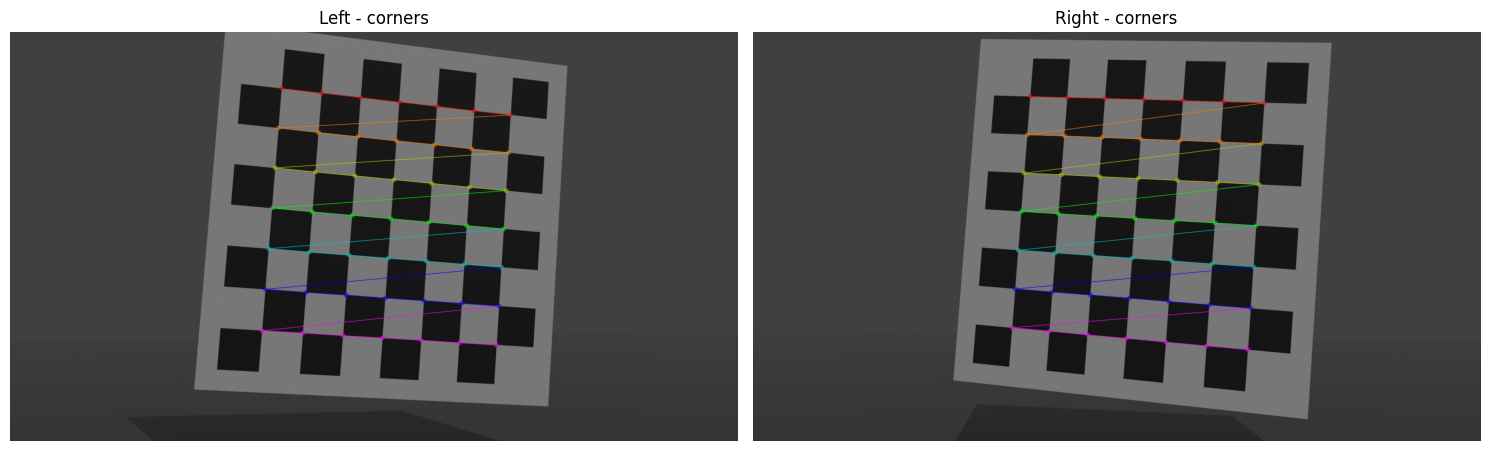

In [151]:
okL, cornersL, imgL = detect_chessboard_corners(REF_LEFT, pattern_size)
okR, cornersR, imgR = detect_chessboard_corners(REF_RIGHT, pattern_size)

print(f"Corner detection - Left: {okL} | Right: {okR}")
if okL: print("Left corners shape :", cornersL.shape)
if okR: print("Right corners shape:", cornersR.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(imgL); ax1.set_title("Left - corners"); ax1.axis("off")
ax2.imshow(imgR); ax2.set_title("Right - corners"); ax2.axis("off")
plt.tight_layout(); plt.show()



### debug

In [ ]:
# nx, ny = pattern_size  # (7,7)
# objp = np.zeros((nx * ny, 3), np.float32)
# objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
# objp *= square_size

# CB_LEFT  = sorted(glob.glob(str(CB_DIR / "*Left*.png")))
# CB_RIGHT = sorted(glob.glob(str(CB_DIR / "*Right*.png")))

# objpoints, imgpointsL, imgpointsR = [], [], []
# bad_pairs = []

# for left_path, right_path in zip(CB_LEFT, CB_RIGHT):
#     okL, cornersL, _ = detect_chessboard_corners(left_path, pattern_size)
#     okR, cornersR, _ = detect_chessboard_corners(right_path, pattern_size)

#     if okL and okR:
#         objpoints.append(objp.copy())
#         imgpointsL.append(cornersL.astype(np.float32))
#         imgpointsR.append(cornersR.astype(np.float32))
#     else:
#         bad_pairs.append((Path(left_path).name, Path(right_path).name, okL, okR))

# print("Good pairs:", len(objpoints))
# print("Bad pairs :", len(bad_pairs))
# print("Bad details:", bad_pairs)


Good pairs: 3
Bad pairs : 1
Bad details: [('c3Left.png', 'c3Right.png', False, False)]


# Calibration mono (Left + Right)

Sur 4 images disponibles, seules 3 ont une détectionn de coins valide. la calibration n'utilise que les vues où les coins du damier sont détectés correctement.

- RMS = 0.038 px / 0.040 px : represente l'erreur moyenne de reprojection en pixels. ici il est très faible donc la calibration est cohérente sur les images utilisées, mais avec seulement 3 vues la robustesse est limitée. En pratique un il est bon entre 0.2 et 1 px.

- K_L et K_R = K (fx, 0, 0; 0, fy, 0; cx, cy, 1)
left : fx ≈ 2099.15, fy ≈ 2099.22 et right: fx ≈ 2099.89, fy ≈ 2099.76 bon signe les deux caméras se ressemblent

- cx, cy: (≈ 960, 539) centre optique de l'image

K contient les paramètres intrinsèques : fx, fy (focale en pixels) et cx, cy (point principal). Ils sont proches entre les deux caméras, ce qui est attendu pour un système stéréo similaire.

- dist_L et dist_R : d'abord openCV retourne (k1​,k2​,p1​,p2​,k3​) 
    - k1, k2, K3 : distorsion radiale (barillet/coussinet)
    - p1, p2 : distorsion tangentielle (mauvais alignement lentille/capteur)
Les coefficients de distorsion modélisent les déformations optiques. Avec peu d’images, certains coefficients (notamment k3) peuvent varier fortement car le modèle s’ajuste sur un petit dataset.

---

Plus de vues, surtout avec différentes orientations et positions du damier, améliore la stabilité et réduit les incertitudes

---

Avec trop peu de vues, l’estimation est moins contrainte, donc les paramètres peuvent être corrects sur ces images mais mauvais en généralisation.

---

J’ai 4 images par caméra, mais seules 3 ont une détection de damier valide, donc la calibration utilise ces 3 vues. La calibration mono estime K (fx, fy, cx, cy) et la distorsion. Le RMS est l’erreur de reprojection moyenne en pixels : ici ~0.04 px, donc la projection du modèle colle très bien aux coins détectés sur les images utilisées. Cependant, avec seulement 3 vues, certains coefficients de distorsion peuvent être moins robustes; plus d’images et des orientations variées stabilisent les paramètres.

In [162]:
def calibrate_mono(image_paths, pattern_size, square_size):
    """
    j'associe les points 3D connus aux points 2D détectés dans chaque image, puis openCV estime
    la matrice intrinsèque K et les coefficients de distorsion en minimisant l'erreur de reprojection.
    - build_object_points pour obtenir les coordonnées 3D des coins du damier
    - detect_chessboard_corners pour chaque image
    - cv2.calibrateCamera pour la calibration
    - je vérifie que toutes les images ont la même taille

    """
    objp = build_object_points(pattern_size, square_size)

    obj_points, img_points, used_images = [], [], []
    image_size = None

    for p in image_paths:
        ok, corners, _ = detect_chessboard_corners(p, pattern_size)
        if not ok:
            continue

        img = cv2.imread(str(p))
        h, w = img.shape[:2]

        if image_size is None:
            image_size = (w, h)
        else:
            #  sécurité si une image n'a pas la même taille
            if image_size != (w, h):
                raise ValueError(
                    f"Image size mismatch: {p} a {(w, h)} au lieu de {image_size}"
                )

        obj_points.append(objp.copy())
        img_points.append(corners.astype(np.float32))  #  cast explicite
        used_images.append(p)

    #  sécurité si pas assez d'images valides
    if len(obj_points) < 3:
        raise RuntimeError(
            f"Calibration impossible: seulement {len(obj_points)} images valides"
        )

    #  flag pour stabiliser la calibration avec peu d'images (optionnel)
    # calib_flags = cv2.CALIB_ZERO_TANGENT_DIST

    rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, image_size, None, None
        # , flags=calib_flags
    )

    return {
        "rms": float(rms),
        "K": K,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "used_images": used_images,
        "image_size": image_size
    }


In [163]:
left_paths  = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Left*.*")))
right_paths = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Right*.*")))

print("Found Left images :", len(left_paths))
print("Found Right images:", len(right_paths))

calibL = calibrate_mono(left_paths, pattern_size, square_size)
calibR = calibrate_mono(right_paths, pattern_size, square_size)

print("\nLEFT CAMERA")
print("RMS:", calibL["rms"])
print("K_L:\n", calibL["K"])
print("dist_L:", calibL["dist"].ravel())
print("Used images:", len(calibL["used_images"]))
print("Used list  :", [Path(p).name for p in calibL["used_images"]])  
print("image_size :", calibL["image_size"])                          

print("\nRIGHT CAMERA")
print("RMS:", calibR["rms"])
print("K_R:\n", calibR["K"])
print("dist_R:", calibR["dist"].ravel())
print("Used images:", len(calibR["used_images"]))
print("Used list  :", [Path(p).name for p in calibR["used_images"]])  
print("image_size :", calibR["image_size"])                          

#  sécurité avant stereo
assert calibL["image_size"] == calibR["image_size"], "Left/Right image_size mismatch!"


Found Left images : 4
Found Right images: 4

LEFT CAMERA
RMS: 0.03827474159298447
K_L:
 [[2.09991466e+03 0.00000000e+00 9.60187506e+02]
 [0.00000000e+00 2.09991624e+03 5.38595868e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_L: [-6.88040473e-03  1.42797318e-01 -1.76651995e-04  1.46989865e-04
 -3.30431598e-01]
Used images: 4
Used list  : ['c1Left.png', 'c2Left.png', 'c3Left.png', 'c4Left.png']
image_size : (1920, 1080)

RIGHT CAMERA
RMS: 0.04181482740498828
K_R:
 [[2.10006435e+03 0.00000000e+00 9.59760241e+02]
 [0.00000000e+00 2.09997317e+03 5.39852296e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_R: [-5.48447501e-03  2.17369294e-01  7.18268312e-06  2.78567662e-05
 -2.47917238e+00]
Used images: 4
Used list  : ['c1Right.png', 'c2Right.png', 'c3Right.png', 'c4Right.png']
image_size : (1920, 1080)


In [171]:
# TEST ORDER (1 seule paire) : c1
pL = CB_DIR / "c1Left.png"
pR = CB_DIR / "c1Right.png"

okL, cL, _ = detect_chessboard_corners(pL, pattern_size)
okR, cR, _ = detect_chessboard_corners(pR, pattern_size)
print("okL/okR:", okL, okR, "shapes:", cL.shape, cR.shape)

# affiche 4 coins "repères" : (0), (cols-1), (-cols), (-1)
cols, rows = pattern_size
idxs = [0, cols-1, (rows-1)*cols, rows*cols-1]
print("idxs:", idxs)

print("LEFT repère:", [cL[i,0].tolist() for i in idxs])
print("RIGHT repère:", [cR[i,0].tolist() for i in idxs])


okL/okR: True True shapes: (49, 1, 2) (49, 1, 2)
idxs: [0, 6, 42, 48]
LEFT repère: [[648.3359375, 267.44598388671875], [999.4168090820312, 325.2793884277344], [914.4091796875, 739.6796875], [1249.0726318359375, 712.1669311523438]]
RIGHT repère: [[647.2940063476562, 288.75079345703125], [1105.41748046875, 319.27667236328125], [782.2376708984375, 738.093017578125], [1290.406982421875, 716.5336303710938]]


# Calibration stéreo (R, T, E, F)

Estimation de la gémotrie relative entre les deux caméras: 
- R : rotation 
- T : translation 
- E : matrice essentielle
- F: matrice fondamentale
---

La calibration stéréo utilise uniquement les paires gauche-droite où le damier est détecté dans les deux images. Ici, 3 paires sont exploitables.

---

Le RMS stéréo est plus élevé que le RMS mono car il mesure la cohérence entre les deux caméras. Avec seulement 3 paires, l’erreur reste acceptable.

---

matrice de rotation: La matrice R décrit l’orientation relative entre les deux caméras. Ici on observe une rotation modérée, cohérente avec un montage réel.

---

Le vecteur T représente la translation entre les deux caméras, principalement horizontale, ce qui correspond à la baseline du système stéréo.


---
La matrice essentielle encode la relation géométrique 3D entre les deux caméras.

---
La matrice fondamentale relie les points correspondants entre les deux images et permet de calculer les lignes épipolaires.


In [ ]:
def calibrate_stereo(obj_points, img_points_L, img_points_R, image_size,
                     K_L, dist_L, K_R, dist_R):
    """
    La calibration stéréo estime la rotation et la translation entre les deux caméras.
    On fixe les paramètres intrinsèques K et dist issus de la calibration mono pour resoudre
    l'ambiguité entre intrinsèque et extrinsèque.
    """
    flags = cv2.CALIB_FIX_INTRINSIC  # on garde K et dist issus du mono

    #  cast propre (OpenCV calibration préfère float64)
    K_L = np.asarray(K_L, dtype=np.float64)
    K_R = np.asarray(K_R, dtype=np.float64)
    dist_L = np.asarray(dist_L, dtype=np.float64).reshape(-1, 1)
    dist_R = np.asarray(dist_R, dtype=np.float64).reshape(-1, 1)

    # critère de convergence 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1e-7)  

    rms, K_L, dist_L, K_R, dist_R, R, T, E, F = cv2.stereoCalibrate(
        obj_points,
        img_points_L,
        img_points_R,
        K_L, dist_L,
        K_R, dist_R,
        image_size,
        flags=flags,
     
        criteria=criteria
    )

    return {
        "rms": float(rms),
        "R": R,
        "T": T,
        "E": E,
        "F": F
    }


## Exécution

In [168]:
# Récupérer les points stéréo
obj_pts, imgL_pts, imgR_pts, img_size = collect_stereo_points(
    left_paths, right_paths, pattern_size, square_size
)

print("Stereo pairs used:", len(obj_pts))
print("image_size:", img_size)

# (optionnel) voir les shapes pour debug
print("distL shape:", calibL["dist"].shape, "distR shape:", calibR["dist"].shape)  # >>> AJOUT

#  Calibration stéréo
stereo = calibrate_stereo(
    obj_pts, imgL_pts, imgR_pts, img_size,
    calibL["K"], calibL["dist"],
    calibR["K"], calibR["dist"]
)

print("\nSTEREO CALIBRATION")
print("RMS:", stereo["rms"])
print("R:\n", stereo["R"])
print("det(R):", np.linalg.det(stereo["R"]))  # >>> AJOUT
print("T:\n", stereo["T"].ravel())
print("||T||:", float(np.linalg.norm(stereo["T"])))
print("E:\n", stereo["E"])
print("F:\n", stereo["F"])


Stereo pairs used: 4
image_size: (1920, 1080)
distL shape: (1, 5) distR shape: (1, 5)

STEREO CALIBRATION
RMS: 12.367999246857686
R:
 [[ 0.94155811  0.01626675  0.33645761]
 [-0.0158137   0.9998666  -0.00408688]
 [-0.33647921 -0.0014726   0.94168974]]
det(R): 1.0
T:
 [-7.33979055  0.07793011  1.08772622]
||T||: 7.420360281046928
E:
 [[-9.02088812e-03 -1.08769588e+00  7.78313935e-02]
 [-1.44552948e+00  6.88516800e-03  7.27777924e+00]
 [ 4.26935039e-02 -7.34007911e+00  3.77667018e-03]]
F:
 [[ 6.04328773e-09  7.28670403e-07 -5.07753063e-04]
 [ 9.68433460e-07 -4.61271950e-09 -1.11660588e-02]
 [-5.88675704e-04  9.62973263e-03  1.00000000e+00]]


In [169]:
# 0) Recalibrer MONO sur EXACTEMENT les mêmes paires que la stéréo
retL2, K_L2, dist_L2, rvecsL2, tvecsL2 = cv2.calibrateCamera(obj_pts, imgL_pts, img_size, None, None)
retR2, K_R2, dist_R2, rvecsR2, tvecsR2 = cv2.calibrateCamera(obj_pts, imgR_pts, img_size, None, None)

print("\nMONO (paired dataset) LEFT  RMS:", retL2, "dist shape:", dist_L2.shape)
print("MONO (paired dataset) RIGHT RMS:", retR2, "dist shape:", dist_R2.shape)

# 1) Calibration stéréo avec ces intrinsèques-là
stereo = calibrate_stereo(
    obj_pts, imgL_pts, imgR_pts, img_size,
    K_L2, dist_L2,
    K_R2, dist_R2
)

print("\nSTEREO CALIBRATION (paired K/dist)")
print("RMS:", stereo["rms"])
print("det(R):", np.linalg.det(stereo["R"]))
print("T:", stereo["T"].ravel(), "||T||:", float(np.linalg.norm(stereo["T"])))



MONO (paired dataset) LEFT  RMS: 0.03827474159298447 dist shape: (1, 5)
MONO (paired dataset) RIGHT RMS: 0.04181482740498828 dist shape: (1, 5)

STEREO CALIBRATION (paired K/dist)
RMS: 12.367999246857686
det(R): 1.0
T: [-7.33979055  0.07793011  1.08772622] ||T||: 7.420360281046928


In [170]:
print("calibL dist:", calibL["dist"].ravel())
print("dist_L2   :", dist_L2.ravel())


calibL dist: [-6.88040473e-03  1.42797318e-01 -1.76651995e-04  1.46989865e-04
 -3.30431598e-01]
dist_L2   : [-6.88040473e-03  1.42797318e-01 -1.76651995e-04  1.46989865e-04
 -3.30431598e-01]


In [157]:
import numpy as np
import cv2

def reproj_error_per_view(obj_points, img_points, rvecs, tvecs, K, dist):
    errs = []
    for i, (objp, imgp) in enumerate(zip(obj_points, img_points)):
        proj, _ = cv2.projectPoints(objp, rvecs[i], tvecs[i], K, dist)
        proj = proj.reshape(-1,2)
        imgp2 = imgp.reshape(-1,2)
        e = np.linalg.norm(proj - imgp2, axis=1).mean()
        errs.append(e)
    return np.array(errs)

# rebuild stereo points (on veut être sûr même ordre)
obj_pts, imgL_pts, imgR_pts, img_size = collect_stereo_points(left_paths, right_paths, pattern_size, square_size)

# mono calibration WITHOUT changing your stored calibL/calibR
# (just to get rvecs/tvecs for error inspection)
retL, K_L, dist_L, rvecsL, tvecsL = cv2.calibrateCamera(obj_pts, imgL_pts, img_size, None, None)
retR, K_R, dist_R, rvecsR, tvecsR = cv2.calibrateCamera(obj_pts, imgR_pts, img_size, None, None)

errL = reproj_error_per_view(obj_pts, imgL_pts, rvecsL, tvecsL, K_L, dist_L)
errR = reproj_error_per_view(obj_pts, imgR_pts, rvecsR, tvecsR, K_R, dist_R)

print("Per-view reprojection error LEFT :", errL)
print("Per-view reprojection error RIGHT:", errR)
print("Mean L/R:", errL.mean(), errR.mean())


Per-view reprojection error LEFT : [0.0355583  0.03302567 0.03445717 0.03648276]
Per-view reprojection error RIGHT: [0.03601778 0.03726076 0.04220033 0.03910837]
Mean L/R: 0.034880973 0.038646806


# LIGNES ÉPIPOLAIRES (avec F issue de stereoCalibrate)



In [67]:
imgL_bgr = cv2.imread(str(REF_LEFT))
imgR_bgr = cv2.imread(str(REF_RIGHT))

imgL = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)


"""
Les coins du damier fournissent des correspondances exactes entre les deux images.
"""
okL, cornersL, _ = detect_chessboard_corners(REF_LEFT, pattern_size)
okR, cornersR, _ = detect_chessboard_corners(REF_RIGHT, pattern_size)

if not (okL and okR):
    raise ValueError("Damier non détecté sur la paire de référence.")

"""
chque indicie i correspond à une paire de points correspondants
"""
ptsL = cornersL.reshape(-1, 2)  # (N,2)
ptsR = cornersR.reshape(-1, 2)  # (N,2)


"""
À partir de F, OpenCV calcule pour chaque point sa ligne épipolaire dans l’autre image.
"""
F = stereo["F"].astype(np.float64)

# lignes dans RIGHT correspondant aux points LEFT
linesR = cv2.computeCorrespondEpilines(
    ptsL.reshape(-1, 1, 2), 1, F
).reshape(-1, 3)

# lignes dans LEFT correspondant aux points RIGHT
linesL = cv2.computeCorrespondEpilines(
    ptsR.reshape(-1, 1, 2), 2, F
).reshape(-1, 3)

def draw_epilines(img_rgb, lines, pts, n=4):
    """
    lines : (N,3) avec ax + by + c = 0
    pts   : (N,2) points associés
    """
    h, w = img_rgb.shape[:2]
    out = img_rgb.copy()

    n = min(n, len(lines))
    for i in range(n):
        a, b, c = lines[i]

        if abs(b) < 1e-9:
            continue

        x0, x1 = 0, w - 1
        y0 = int(round(-(a * x0 + c) / b))
        y1 = int(round(-(a * x1 + c) / b))

        cv2.line(out, (x0, y0), (x1, y1), (0, 255, 0), 1)

        x, y = pts[i]
        cv2.circle(out, (int(x), int(y)), 4, (255, 0, 0), -1)

    return out




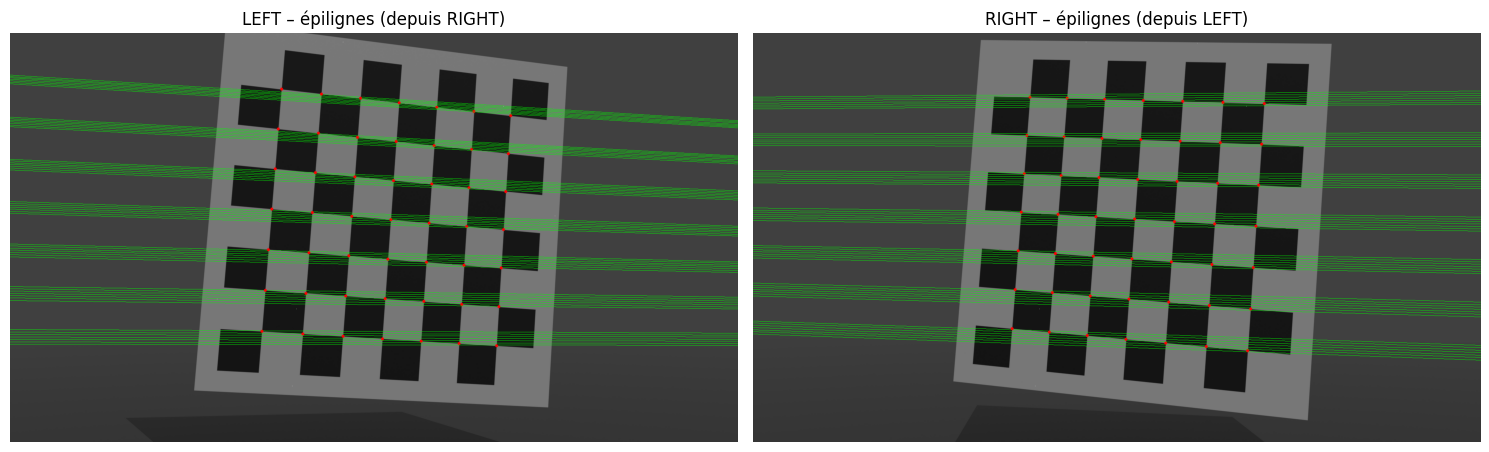

In [69]:
imgL_draw = draw_epilines(imgL, linesL, ptsL, n=60)
imgR_draw = draw_epilines(imgR, linesR, ptsR, n=60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(imgL_draw); ax1.set_title("LEFT – épilignes (depuis RIGHT)"); ax1.axis("off")
ax2.imshow(imgR_draw); ax2.set_title("RIGHT – épilignes (depuis LEFT)"); ax2.axis("off")
plt.tight_layout(); plt.show()


# Projection P1 et P2 

je fixe la caméra gauche comme repère monde. La caméra droite est définie par la rotation R et la translation T issues de la calibration stéréo.

---

R et T décrivent la transformation entre les deux caméras, indépendamment de la scène observée.

---

Les matrices de projection combinent les paramètres intrinsèques et extrinsèques pour permettre la projection et la triangulation 3D.

---

Les rvec/tvec issus de la calibration mono décrivent la pose du damier pour chaque image.
Pour la stéréo, j’utilise la rotation et la translation entre les deux caméras, issues de la calibration stéréo, afin de construire les matrices de projection P1 et P2 nécessaires à la triangulation.


In [71]:
K_L = calibL["K"]
K_R = calibR["K"]
R = stereo["R"]
T = stereo["T"]


P1 = K_L @ np.hstack((np.eye(3), np.zeros((3, 1))))

P2 = K_R @ np.hstack((R, T))


print("P1 shape:", P1.shape)
print("P2 shape:", P2.shape)


P1 shape: (3, 4)
P2 shape: (3, 4)


# Triangulation 3D (damier)

La triangulation reconstruit la position 3D d’un point en intersectant les deux rayons provenant des caméras via P1 et P2.

Corner detection - Left: True | Right: True
N points: 49
ptsL shape: (2, 49) ptsR shape: (2, 49)
X_h shape: (4, 49)
X shape: (49, 3)
First 5 points 3D:
 [[-2.509167  -3.9516091 21.553856 ]
 [-1.4351846 -3.8547864 21.652035 ]
 [-0.3718241 -3.7622852 21.768345 ]
 [ 0.6860261 -3.67364   21.90127  ]
 [ 1.7389868 -3.5890265 22.05932  ]]

Z stats (plane check):
  mean: 21.792526245117188
  std : 0.297870934009552
  min : 21.29530143737793
  max : 22.431015014648438

XY range comparaison (structure):
  Triangulated X range: -3.001952648162842 3.8469157218933105
  Triangulated Y range: -3.9516091346740723 3.0123679637908936
  Expected grid X range: 0.0 6.0
  Expected grid Y range: 0.0 6.0


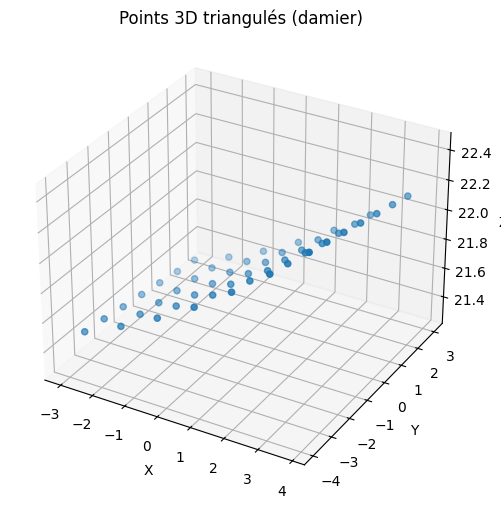

In [ ]:

# [T1] 1) Détection des coins (correspondances 2D) sur la paire de référence
okL, cornersL, _ = detect_chessboard_corners(REF_LEFT, pattern_size)
okR, cornersR, _ = detect_chessboard_corners(REF_RIGHT, pattern_size)

print("Corner detection - Left:", okL, "| Right:", okR)

if not (okL and okR):
    raise ValueError("Damier non détecté sur la paire de référence (triangulation impossible).")

# corners : (N,1,2) -> pts : (2,N) attendu par cv2.triangulatePoints
ptsL = cornersL.reshape(-1, 2).T  # (2, N)
ptsR = cornersR.reshape(-1, 2).T  # (2, N)

N = ptsL.shape[1]
print("N points:", N)
print("ptsL shape:", ptsL.shape, "ptsR shape:", ptsR.shape)

# [T2] 2) Triangulation (sortie en coordonnées homogènes 4D)
# X_h = (4,N) : chaque colonne = (X, Y, Z, W)
X_h = cv2.triangulatePoints(P1, P2, ptsL, ptsR)
print("X_h shape:", X_h.shape)

# [T3] 3) Conversion homogène -> cartésien (division par W)
# X = (N,3)
X = (X_h[:3] / X_h[3]).T
print("X shape:", X.shape)
print("First 5 points 3D:\n", X[:5])

# [T4] 4) Vérification planéité (damier ~ plan => Z quasi constant)
Z = X[:, 2]
print("\nZ stats (plane check):")
print("  mean:", float(np.mean(Z)))
print("  std :", float(np.std(Z)))
print("  min :", float(np.min(Z)))
print("  max :", float(np.max(Z)))

# [T5] 5) Comparaison grossière avec la grille attendue (structure XY)
objp = build_object_points(pattern_size, square_size)  # (N,3)

print("\nXY range comparaison (structure):")
print("  Triangulated X range:", float(X[:,0].min()), float(X[:,0].max()))
print("  Triangulated Y range:", float(X[:,1].min()), float(X[:,1].max()))
print("  Expected grid X range:", float(objp[:,0].min()), float(objp[:,0].max()))
print("  Expected grid Y range:", float(objp[:,1].min()), float(objp[:,1].max()))

# [T6] 6) Visualisation 3D (nuage de points)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Points 3D triangulés (damier)")
plt.show()


# LASER 3D (scans) : rectification + extraction + triangulation

(3, 3) (1, 5)
(3, 3) (1, 5)
(3, 3) (3, 1)
scans: 26 26
example: data/scanLeft\0000.png data/scanRight\scan0000.png


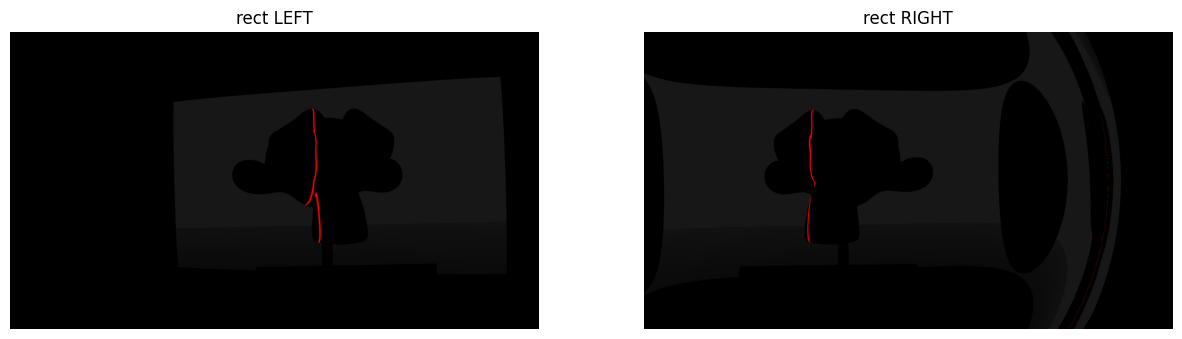

P1_rect: (3, 4) P2_rect: (3, 4)


In [99]:
print(calibL["K"].shape, calibL["dist"].shape)
print(calibR["K"].shape, calibR["dist"].shape)
print(stereo["R"].shape, stereo["T"].shape)

SCAN_LEFT  = sorted(glob.glob(SCAN_LEFT_DIR))
SCAN_RIGHT = sorted(glob.glob(SCAN_RIGHT_DIR))
print("scans:", len(SCAN_LEFT), len(SCAN_RIGHT))
print("example:", SCAN_LEFT[0], SCAN_RIGHT[0])


# for i in range(26):
#     print(i, Path(SCAN_LEFT[i]).name, " <-> ", Path(SCAN_RIGHT[i]).name)
#     print(i, Path(SCAN_RIGHT[i]).name, " <-> ", Path(SCAN_LEFT[i]).name)

idx =14
imgL = cv2.imread(SCAN_LEFT[idx])
imgR = cv2.imread(SCAN_RIGHT[idx])
h, w = imgL.shape[:2]
image_size = (w, h)

# Rectification
R1, R2, P1_rect, P2_rect, Q, roi1, roi2 = cv2.stereoRectify(
    calibL["K"], calibL["dist"],
    calibR["K"], calibR["dist"],
    image_size,
    stereo["R"], stereo["T"],
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=1
)

map1x, map1y = cv2.initUndistortRectifyMap(calibL["K"], calibL["dist"], R1, P1_rect, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(calibR["K"], calibR["dist"], R2, P2_rect, image_size, cv2.CV_32FC1)

rectL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
rectR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB)); ax1.set_title("rect LEFT"); ax1.axis("off")
ax2.imshow(cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB)); ax2.set_title("rect RIGHT"); ax2.axis("off")
plt.show()

print("P1_rect:", P1_rect.shape, "P2_rect:", P2_rect.shape)


In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# ------------------------------------------------------------
# 1) Segmentation laser (simple et efficace)
# ------------------------------------------------------------
def laser_mask_red_score(img_bgr, thresh=40):
    """
    score = R - max(G,B)
    mask = score > thresh
    """
    b, g, r = cv2.split(img_bgr)
    score = r.astype(np.int16) - np.maximum(g, b).astype(np.int16)
    return (score > thresh).astype(np.uint8) * 255

def extract_laser_pixels(mask):
    """
    Retourne tous les pixels laser en (x,y)
    mask: uint8 (0/255)
    """
    ys, xs = np.where(mask > 0)
    return np.stack([xs, ys], axis=1).astype(np.float64)  # (N,2)

# ------------------------------------------------------------
# 2) Épilignes + matching (méthode "pote")
# ------------------------------------------------------------
def epilines_from_points(F, pts, which_image):
    # pts: (N,2)
    if pts is None or len(pts) == 0:
        return None

    F = np.asarray(F, dtype=np.float64)
    if F.shape != (3,3) or not np.isfinite(F).all():
        return None

    pts_ = np.asarray(pts, dtype=np.float64).reshape(-1, 1, 2)
    lines = cv2.computeCorrespondEpilines(pts_, which_image, F)

    if lines is None:
        return None

    return lines.reshape(-1, 3)


def match_points_by_epiline(lines, laser_pts_other, max_dist_px=2.0):
    """
    Pour chaque épiligne (a,b,c), cherche le pixel laser de l'autre image
    le plus proche (distance point-ligne).
    Retourne indices appariés.
    """
    if len(laser_pts_other) == 0:
        return np.empty((0,2), dtype=np.float64), np.empty((0,2), dtype=np.float64)

    Xo = laser_pts_other[:,0]
    Yo = laser_pts_other[:,1]

    matched_other = []
    matched_idx = []

    for i, (a,b,c) in enumerate(lines):
        denom = np.sqrt(a*a + b*b) + 1e-12
        d = np.abs(a*Xo + b*Yo + c) / denom
        j = int(np.argmin(d))
        if d[j] <= max_dist_px:
            matched_other.append(laser_pts_other[j])
            matched_idx.append(i)

    return np.array(matched_idx, dtype=int), np.array(matched_other, dtype=np.float64)

# ------------------------------------------------------------
# 3) Triangulation
# ------------------------------------------------------------
def triangulate_points(P1, P2, ptsL, ptsR):
    """
    ptsL, ptsR : (N,2) en pixels (x,y)
    """
    if len(ptsL) == 0:
        return np.empty((0,3))
    Xh = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)  # (4,N)
    X = (Xh[:3] / (Xh[3] + 1e-12)).T
    X = X[np.isfinite(X).all(axis=1)]
    return X

# ------------------------------------------------------------
# 4) Debug dessin épilignes (optionnel)
# ------------------------------------------------------------
def draw_epilines(img_rgb, lines, pts=None, n=50):
    out = img_rgb.copy()
    h, w = out.shape[:2]
    n = min(n, len(lines))
    for i in range(n):
        a,b,c = lines[i]
        if abs(b) < 1e-9:
            continue
        x0, x1 = 0, w-1
        y0 = int(round(-(a*x0 + c)/b))
        y1 = int(round(-(a*x1 + c)/b))
        cv2.line(out, (x0,y0), (x1,y1), (0,255,0), 1)

        if pts is not None:
            x,y = pts[i]
            cv2.circle(out, (int(x),int(y)), 2, (255,0,0), -1)
    return out

# ------------------------------------------------------------
# 5) Pipeline sur un scan
# ------------------------------------------------------------
def process_scan_pair(imgL_bgr, imgR_bgr, F, P1, P2,
                      thresh=40, sample_rate=100, max_dist_px=2.0,
                      do_debug=True,
                      rectify_maps=None):
    # rectify_maps = (map1x,map1y,map2x,map2y) ou None

    if rectify_maps is not None:
        map1x, map1y, map2x, map2y = rectify_maps
        imgL_bgr = cv2.remap(imgL_bgr, map1x, map1y, cv2.INTER_LINEAR)
        imgR_bgr = cv2.remap(imgR_bgr, map2x, map2y, cv2.INTER_LINEAR)

    # 1) Mask + points laser
    maskL = laser_mask_red_score(imgL_bgr, thresh=thresh)
    maskR = laser_mask_red_score(imgR_bgr, thresh=thresh)

    ptsL_all = extract_laser_pixels(maskL)
    ptsR_all = extract_laser_pixels(maskR)

    if len(ptsL_all) == 0 or len(ptsR_all) == 0:
        return np.empty((0,3)), {"L":len(ptsL_all), "R":len(ptsR_all), "sampled":0, "matches":0, "X":0}

    ptsL = ptsL_all[::sample_rate]

    # 2) épilignes
    linesR = epilines_from_points(F, ptsL, which_image=1)
    if linesR is None:
        return np.empty((0,3)), {"L":len(ptsL_all), "R":len(ptsR_all), "sampled":len(ptsL), "matches":0, "X":0}

    # 3) matching
    idxL, ptsR_match = match_points_by_epiline(linesR, ptsR_all, max_dist_px=max_dist_px)
    ptsL_match = ptsL[idxL] if len(idxL) else np.empty((0,2), dtype=np.float64)

    # 4) triangulation
    X = triangulate_points(P1, P2, ptsL_match, ptsR_match)
    X = X[X[:,2] > 0] if len(X) else X

    info = {"L":len(ptsL_all), "R":len(ptsR_all), "sampled":len(ptsL), "matches":len(ptsL_match), "X":len(X)}

    if do_debug:
        print("INFO:", info)

    return X, info


# ------------------------------------------------------------
# 6) Reconstruction complète sur toutes les paires
# ------------------------------------------------------------
def reconstruct_all_scans(SCAN_LEFT, SCAN_RIGHT, F, P1, P2,
                          thresh=40, sample_rate=100, max_dist_px=2.0,
                          debug_every=5):
    X_all = []
    infos = []

    rectify_maps = (map1x, map1y, map2x, map2y)  # <-- utilise TES maps calculées

    for i, (pL, pR) in enumerate(zip(SCAN_LEFT, SCAN_RIGHT)):
        imgL = cv2.imread(pL)
        imgR = cv2.imread(pR)
        if imgL is None or imgR is None:
            continue

        do_debug = (i % debug_every == 0)

        X, info = process_scan_pair(
            imgL, imgR, F, P1, P2,
            thresh=thresh, sample_rate=sample_rate,
            max_dist_px=max_dist_px, do_debug=do_debug,
            rectify_maps=rectify_maps
        )

        infos.append((i, info))
        if len(X):
            X_all.append(X)

    X_all = np.vstack(X_all) if len(X_all) else np.empty((0,3))
    print("TOTAL 3D points:", len(X_all))
    return X_all, infos



INFO: {'L': 1308, 'R': 2845, 'sampled': 14, 'matches': 14, 'X': 7}
INFO: {'L': 583, 'R': 683, 'sampled': 6, 'matches': 6, 'X': 5}
TOTAL 3D points: 160


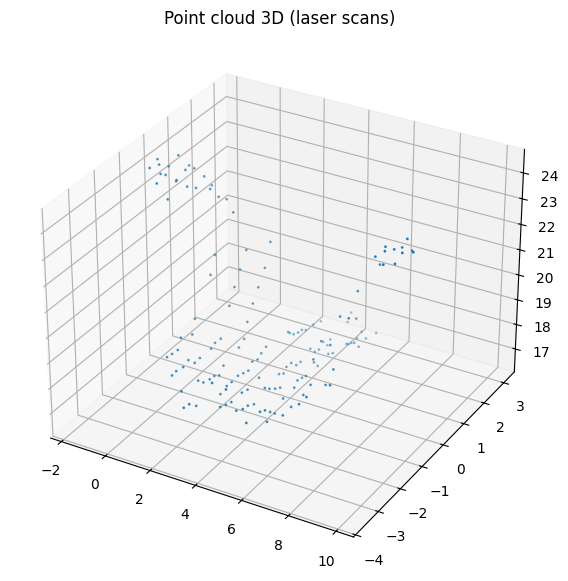

In [120]:
F = stereo["F"].astype(np.float64)

# P1_rect, P2_rect viennent de stereoRectify (comme tu as fait)
# reconstruct :
X_all, infos = reconstruct_all_scans(
    SCAN_LEFT, SCAN_RIGHT,
    F, P1_rect, P2_rect,
    thresh=40, sample_rate=100, max_dist_px=2.0,
    debug_every=10
)

# plot final
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_all[:,0], X_all[:,1], X_all[:,2], s=1)
ax.set_title("Point cloud 3D (laser scans)")
plt.show()


# Matrice fondamentale F

- Estimer F à partir de correspondances (coins du damier)
- F 8POINT
- F RANSAC
- Comparer 8POINT vs RANSAC
- Vérifier la contrainte x'^T F x ≈ 0



In [4]:
# ============================================================================
# 2. MATRICE FONDAMENTALE F
# ============================================================================
# 
# OBJECTIF : Calculer la matrice fondamentale F qui encode la contrainte
#            épipolaire : x'ᵀ F x = 0 pour toute paire de points correspondants
#
# DEUX MÉTHODES :
# 1) THÉORIQUE (formule du cours) : F = [e']ₓ P' P⁺
# 2) PRATIQUE (OpenCV)            : estimation robuste par RANSAC
# ============================================================================

print("\n" + "=" * 80)
print("ÉTAPE 2 : MATRICE FONDAMENTALE F")
print("=" * 80)


# ----------------------------------------------------------------------------
# 2.1 : Détection des correspondances sur la paire de référence
# ----------------------------------------------------------------------------

print("\n[2.1] Détection des coins du damier sur la paire de référence...")

resL = detect_chessboard_corners(REF_LEFT, PATTERN_SIZE)
resR = detect_chessboard_corners(REF_RIGHT, PATTERN_SIZE)

if not (resL["success"] and resR["success"]):
    raise RuntimeError(
        f"Damier non détecté sur {REF_LEFT.name} ou {REF_RIGHT.name}.\n"
        f"Essaie avec c2Left.png/c2Right.png à la place."
    )

ptsL = resL["corners"].astype(np.float64)  # (N, 2)
ptsR = resR["corners"].astype(np.float64)  # (N, 2)

print(f"✓ {len(ptsL)} correspondances détectées (attendu: 49 pour un damier 7x7)")


# ----------------------------------------------------------------------------
# 2.2 : MÉTHODE PRATIQUE - Estimation avec OpenCV (8-POINT + RANSAC)
# ----------------------------------------------------------------------------

print("\n[2.2] Calcul de F avec OpenCV...")

# Méthode 8-POINT (sans robustesse)
F_8point, _ = cv2.findFundamentalMat(ptsL, ptsR, method=cv2.FM_8POINT)
if F_8point is None:
    raise RuntimeError("Échec estimation F (8-POINT)")
F_8point = F_8point / np.linalg.norm(F_8point)

print("F (8-POINT) calculée")

# Méthode RANSAC (robuste aux outliers)
F_RANSAC, mask = cv2.findFundamentalMat(
    ptsL, ptsR,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,  # seuil en pixels
    confidence=0.99
)
if F_RANSAC is None:
    raise RuntimeError("Échec estimation F (RANSAC)")

F_RANSAC = F_RANSAC / np.linalg.norm(F_RANSAC)
inliers_L = ptsL[mask.ravel() == 1]
inliers_R = ptsR[mask.ravel() == 1]

print(f"✓ F (RANSAC) calculée - {len(inliers_L)}/{len(ptsL)} inliers")


# ----------------------------------------------------------------------------
# 2.3 : MÉTHODE THÉORIQUE - Formule du cours F = [e']ₓ P' P⁺
# ----------------------------------------------------------------------------

print("\n[2.3] Calcul de F avec la formule théorique du cours...")

# Helper pour trouver l'index d'une image dans used_images
def find_image_index(used_images, target_path):
    name = Path(target_path).name
    for i, p in enumerate(used_images):
        if Path(p).name == name:
            return i
    return None

# Récupérer les poses (rvec, tvec) de la paire de référence
idxL = find_image_index(calibL["used_images"], REF_LEFT)
idxR = find_image_index(calibR["used_images"], REF_RIGHT)

if idxL is None or idxR is None:
    raise RuntimeError(
        f"Paire {REF_LEFT.name}/{REF_RIGHT.name} non trouvée dans used_images.\n"
        f"Images LEFT disponibles : {[Path(p).name for p in calibL['used_images']]}\n"
        f"Images RIGHT disponibles: {[Path(p).name for p in calibR['used_images']]}"
    )

# Poses du damier dans chaque caméra
rvecL, tvecL = calibL["rvecs"][idxL], calibL["tvecs"][idxL]
rvecR, tvecR = calibR["rvecs"][idxR], calibR["tvecs"][idxR]

# Conversion Rodrigues -> matrices de rotation
R_L, _ = cv2.Rodrigues(rvecL)
R_R, _ = cv2.Rodrigues(rvecR)

# ÉTAPE CRITIQUE : Calcul de la pose RELATIVE de RIGHT par rapport à LEFT
# Le damier est le même objet vu par les deux caméras
# On veut exprimer la caméra RIGHT dans le repère de LEFT
R_rel = R_R @ R_L.T
T_rel = tvecR.reshape(3, 1) - R_rel @ tvecL.reshape(3, 1)

print(f"Pose relative calculée:")
print(f"  R_rel:\n{R_rel}")
print(f"  T_rel: {T_rel.ravel()}")

# Matrices intrinsèques
K_L = calibL["K"]
K_R = calibR["K"]

# Construction des matrices de projection P = K [R | t]
# LEFT = référence (identité)
P_L = K_L @ np.hstack([np.eye(3), np.zeros((3, 1))])

# RIGHT dans le repère LEFT
P_R = K_R @ np.hstack([R_rel, T_rel])

print(f"\nMatrices de projection construites:")
print(f"  P_L shape: {P_L.shape}")
print(f"  P_R shape: {P_R.shape}")

# Calcul de l'épipôle e' (projection du centre optique LEFT dans RIGHT)
# Le centre optique de LEFT en coordonnées monde est : C_L = -R_L^T @ t_L
C_L_world = -R_L.T @ tvecL.reshape(3, 1)

# Projection dans l'image RIGHT
e_prime_h = P_R @ np.vstack([C_L_world, [[1]]])  # coordonnées homogènes
e_prime = (e_prime_h[:3] / e_prime_h[2]).ravel()  # normalisation

print(f"\nÉpipôle e' (dans RIGHT): {e_prime}")

# Matrice antisymétrique [e']ₓ (pour le produit vectoriel)
def skew_symmetric(v):
    """Matrice antisymétrique [v]ₓ tel que [v]ₓ u = v × u"""
    return np.array([
        [0,     -v[2],  v[1]],
        [v[2],   0,    -v[0]],
        [-v[1],  v[0],   0]
    ])

e_prime_cross = skew_symmetric(e_prime)

# Pseudo-inverse de P_L
P_L_pinv = np.linalg.pinv(P_L)

# FORMULE DU COURS : F = [e']ₓ P' P⁺
F_theorique = e_prime_cross @ P_R @ P_L_pinv

# Normalisation (pour comparaison)
F_theorique = F_theorique / np.linalg.norm(F_theorique)

print(f"\n✓ F (formule théorique) calculée")
print(f"F_theorique =")
print(F_theorique)


# ----------------------------------------------------------------------------
# 2.4 : Vérification de la contrainte épipolaire x'ᵀ F x ≈ 0
# ----------------------------------------------------------------------------

print("\n[2.4] Vérification de la contrainte épipolaire...")

def epipolar_residuals(F, ptsL, ptsR):
    """
    Calcule |x'ᵀ F x| pour chaque paire de points.
    
    Contrainte épipolaire : x'ᵀ F x = 0
    → Plus le résidu est petit, mieux F encode la géométrie épipolaire
    """
    # Coordonnées homogènes
    ptsL_h = np.hstack([ptsL, np.ones((len(ptsL), 1))])  # (N, 3)
    ptsR_h = np.hstack([ptsR, np.ones((len(ptsR), 1))])  # (N, 3)
    
    # x'ᵀ F x
    Fx = (F @ ptsL_h.T).T                    # (N, 3)
    vals = np.sum(ptsR_h * Fx, axis=1)       # (N,)
    
    return np.abs(vals)


# Calcul des résidus pour chaque méthode
err_8point = epipolar_residuals(F_8point, ptsL, ptsR)
err_RANSAC = epipolar_residuals(F_RANSAC, inliers_L, inliers_R)
err_theorique = epipolar_residuals(F_theorique, ptsL, ptsR)

print("\nRésidus |x'ᵀ F x| (plus petit = meilleur):")
print(f"  8-POINT    : mean={err_8point.mean():.6f} px | max={err_8point.max():.6f} px")
print(f"  RANSAC     : mean={err_RANSAC.mean():.6f} px | max={err_RANSAC.max():.6f} px")
print(f"  THÉORIQUE  : mean={err_theorique.mean():.6f} px | max={err_theorique.max():.6f} px")


# ----------------------------------------------------------------------------
# 2.5 : Sélection de la meilleure matrice F
# ----------------------------------------------------------------------------

print("\n[2.5] Sélection de la meilleure matrice F...")

# Comparaison : on garde celle avec les plus petits résidus
errors_dict = {
    "F_8point": err_8point.mean(),
    "F_RANSAC": err_RANSAC.mean(),
    "F_theorique": err_theorique.mean()
}

best_name = min(errors_dict, key=errors_dict.get)

if best_name == "F_8point":
    F = F_8point
elif best_name == "F_RANSAC":
    F = F_RANSAC
else:
    F = F_theorique

print(f"\n✓ Meilleure matrice : {best_name} (résidu moyen = {errors_dict[best_name]:.6f})")
print(f"\nMatrice fondamentale finale F:")
print(F)


# ----------------------------------------------------------------------------
# REMARQUES POUR L'ORAL
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("NOTES POUR L'ORAL - MATRICE FONDAMENTALE")
print("=" * 80)
print("""
1. FORMULE THÉORIQUE : F = [e']ₓ P' P⁺
   - e' = épipôle (projection du centre optique LEFT dans RIGHT)
   - [e']ₓ = matrice antisymétrique (encode le produit vectoriel)
   - P' = matrice de projection de la caméra RIGHT
   - P⁺ = pseudo-inverse de P (matrice LEFT)
   
2. POURQUOI CETTE FORMULE ?
   - Un point x dans LEFT définit un rayon 3D : r = P⁺ x
   - Ce rayon se projette en une ligne dans RIGHT : l' = P' r
   - Cette ligne passe par l'épipôle e' → l' = [e']ₓ (P' P⁺ x) = F x
   
3. MÉTHODE PRATIQUE (OpenCV)
   - On utilise RANSAC pour être robuste aux outliers
   - Estimation directe à partir des correspondances
   - Plus simple et plus robuste en pratique
   
4. CONTRAINTE ÉPIPOLAIRE : x'ᵀ F x = 0
   - Pour toute paire de points correspondants (x, x')
   - F encode la géométrie entre les deux vues
   - Utilisée pour : matching, rectification, triangulation
""")

print("=" * 80)


ÉTAPE 2 : MATRICE FONDAMENTALE F

[2.1] Détection des coins du damier sur la paire de référence...
✓ 49 correspondances détectées (attendu: 49 pour un damier 7x7)

[2.2] Calcul de F avec OpenCV...
F (8-POINT) calculée
✓ F (RANSAC) calculée - 49/49 inliers

[2.3] Calcul de F avec la formule théorique du cours...
Pose relative calculée:
  R_rel:
[[ 0.92213585  0.0195693   0.38637097]
 [-0.01931896  0.9998031  -0.00453125]
 [-0.38638357 -0.00328586  0.92233234]]
  T_rel: [-7.71837895  0.07840078  1.51542051]

Matrices de projection construites:
  P_L shape: (3, 4)
  P_R shape: (3, 4)

Épipôle e' (dans RIGHT): [ 3.03894760e+03 -1.06896308e+02  1.00000000e+00]

✓ F (formule théorique) calculée
F_theorique =
[[ 4.62331486e-07 -3.33850290e-06 -6.07846467e-04]
 [ 4.36113685e-06  7.62884806e-08 -7.92634633e-03]
 [-9.38811732e-04  1.01536903e-02  9.99916409e-01]]

[2.4] Vérification de la contrainte épipolaire...

Résidus |x'ᵀ F x| (plus petit = meilleur):
  8-POINT    : mean=0.000136 px | max=

K/dist shapes:
 LEFT : (3, 3) (1, 5)
 RIGHT: (3, 3) (1, 5)
Stereo R/T shapes: (3, 3) (3, 1)
scans: 26 26
example: data/scanLeft\0000.png data/scanRight\scan0000.png
P1_rect: (3, 4) P2_rect: (3, 4)
[idx=14] laser pts: L=486 R=451


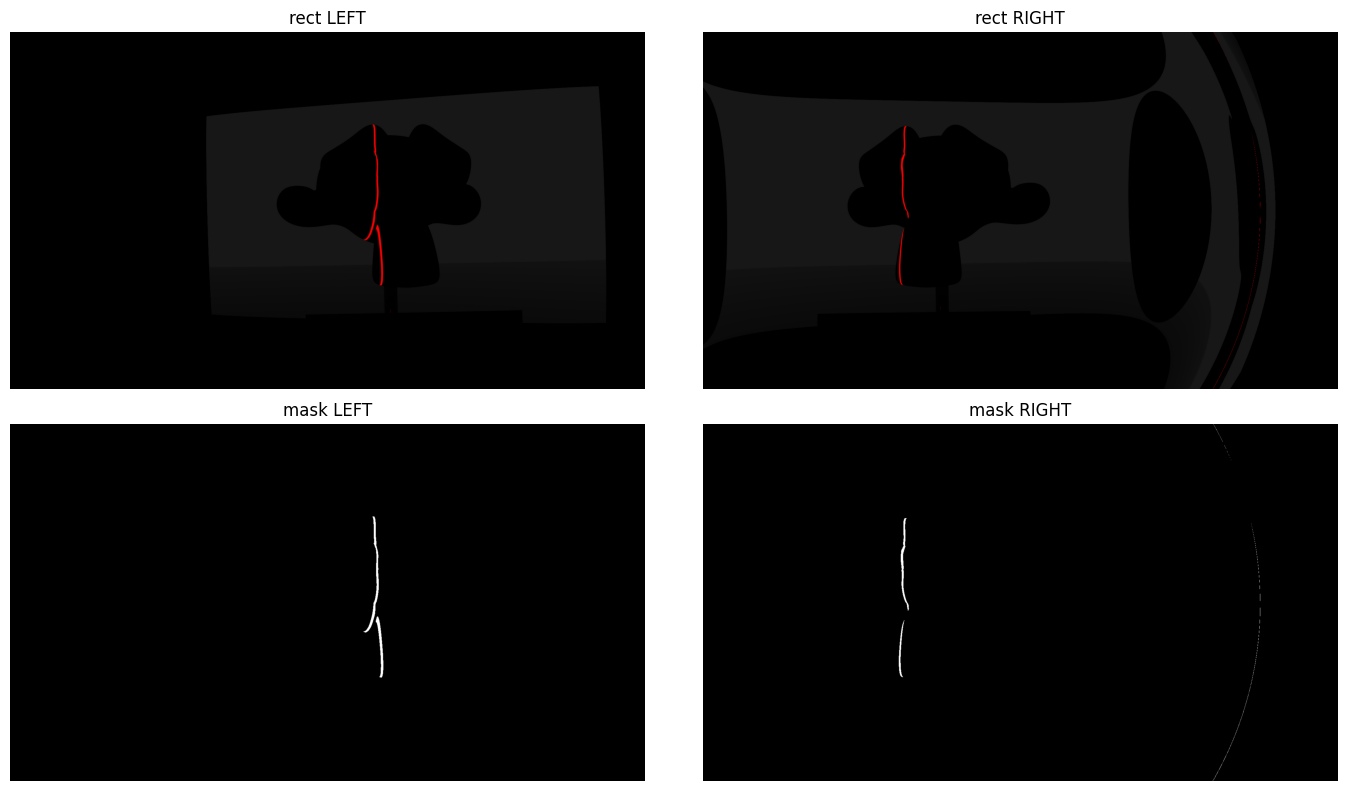

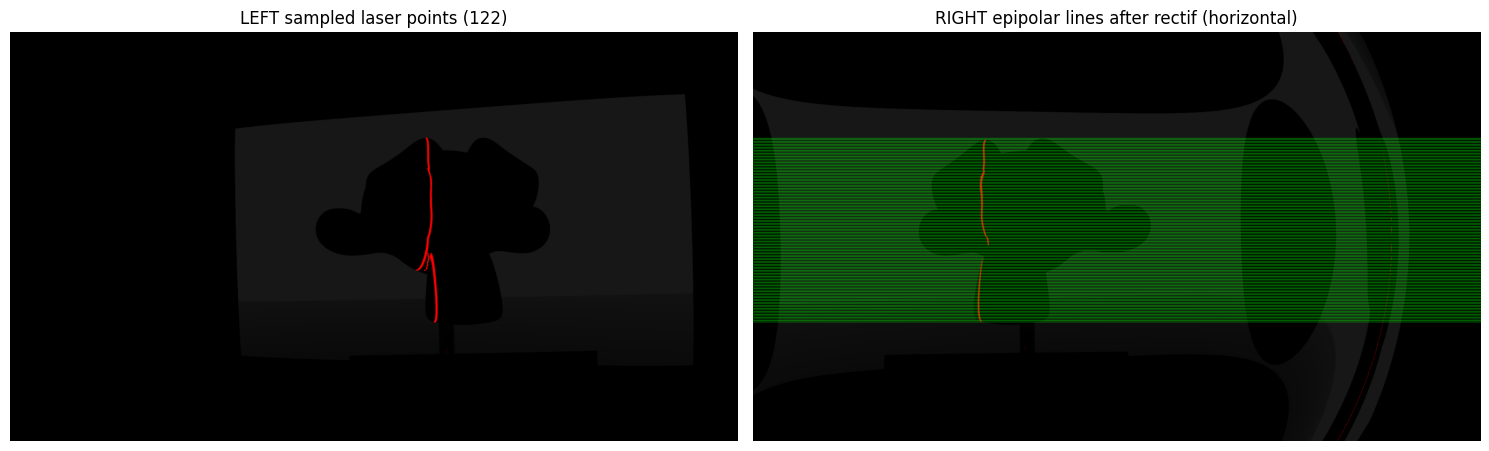

Matched pairs: 451


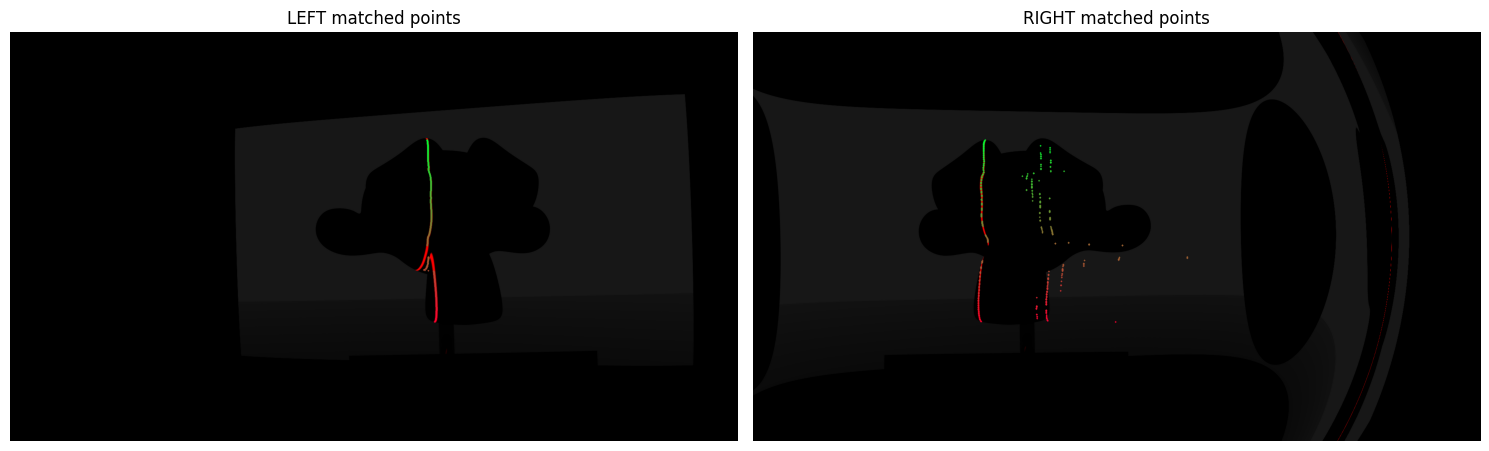

Triangulated 3D points (idx): 451


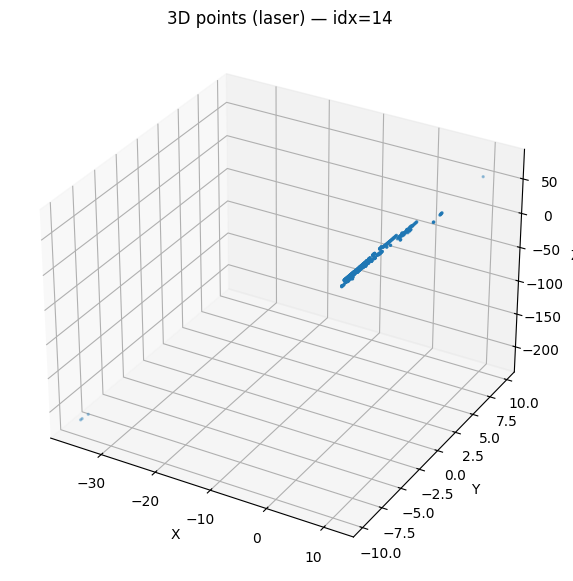

TOTAL 3D points (all scans): 3970


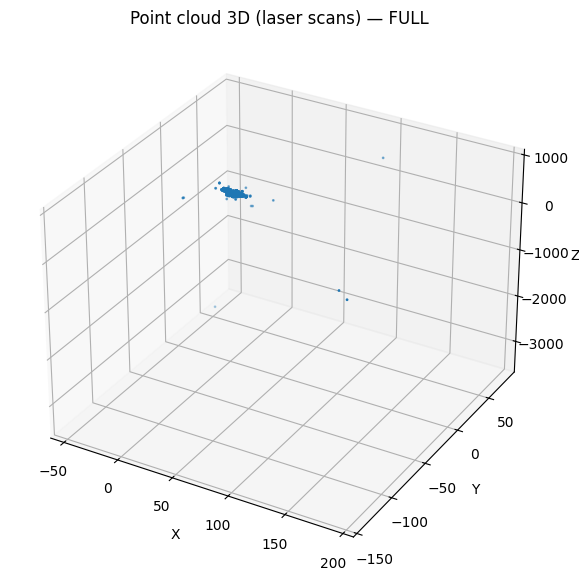

In [123]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

# ============================================================
# 0) Laser utilities
# ============================================================
def laser_mask_red_score(img_bgr, thresh=40):
    b, g, r = cv2.split(img_bgr)
    score = r.astype(np.int16) - np.maximum(g, b).astype(np.int16)
    return (score > thresh).astype(np.uint8) * 255

def extract_laser_points_1perrow(mask, min_pixels_row=2):
    H, W = mask.shape
    pts = []
    for y in range(H):
        xs = np.where(mask[y] > 0)[0]
        if len(xs) >= min_pixels_row:
            pts.append([float(np.mean(xs)), float(y)])
    return np.array(pts, dtype=np.float64)  # (N,2)

def match_by_row_unique(ptsL, ptsR, max_dy=0.5):
    """
    1-1 matching by row: for each yL, find closest yR, but ensure uniqueness.
    Works best after rectification where yL ~ yR.
    """
    if len(ptsL) == 0 or len(ptsR) == 0:
        return np.empty((0,2)), np.empty((0,2))

    # sort by y (already mostly sorted, but safe)
    ptsL = ptsL[np.argsort(ptsL[:,1])]
    ptsR = ptsR[np.argsort(ptsR[:,1])]

    used = np.zeros(len(ptsR), dtype=bool)
    outL, outR = [], []

    yR = ptsR[:,1]
    for xL, yL in ptsL:
        j = int(np.argmin(np.abs(yR - yL)))
        if used[j]:
            continue
        if abs(yR[j] - yL) <= max_dy:
            used[j] = True
            outL.append([xL, yL])
            outR.append([ptsR[j,0], ptsR[j,1]])

    return np.array(outL, dtype=np.float64), np.array(outR, dtype=np.float64)

def triangulate_points(P1, P2, ptsL, ptsR):
    if len(ptsL) == 0:
        return np.empty((0,3))
    Xh = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)  # (4,N)
    X = (Xh[:3] / (Xh[3] + 1e-12)).T
    X = X[np.isfinite(X).all(axis=1)]
    return X

def draw_horizontal_lines(img_rgb, ys, color=(0,255,0), thickness=1):
    out = img_rgb.copy()
    h, w = out.shape[:2]
    for y in ys:
        yy = int(np.clip(round(y), 0, h-1))
        cv2.line(out, (0, yy), (w-1, yy), color, thickness)
    return out

# ============================================================
# 1) Sanity checks + file lists
# ============================================================
print("K/dist shapes:")
print(" LEFT :", calibL["K"].shape, calibL["dist"].shape)
print(" RIGHT:", calibR["K"].shape, calibR["dist"].shape)
print("Stereo R/T shapes:", stereo["R"].shape, stereo["T"].shape)

SCAN_LEFT  = sorted(glob.glob(SCAN_LEFT_DIR))
SCAN_RIGHT = sorted(glob.glob(SCAN_RIGHT_DIR))
print("scans:", len(SCAN_LEFT), len(SCAN_RIGHT))
print("example:", SCAN_LEFT[0], SCAN_RIGHT[0])

# ============================================================
# 2) Choose one scan index for validation
# ============================================================
idx = 14
imgL0 = cv2.imread(SCAN_LEFT[idx])
imgR0 = cv2.imread(SCAN_RIGHT[idx])
if imgL0 is None or imgR0 is None:
    raise FileNotFoundError("Scan images not found at idx")

h, w = imgL0.shape[:2]
image_size = (w, h)

# ============================================================
# 3) Rectification (compute ONCE)
# ============================================================
R1, R2, P1_rect, P2_rect, Q, roi1, roi2 = cv2.stereoRectify(
    calibL["K"], calibL["dist"],
    calibR["K"], calibR["dist"],
    image_size,
    stereo["R"], stereo["T"],
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=1
)

map1x, map1y = cv2.initUndistortRectifyMap(
    calibL["K"], calibL["dist"], R1, P1_rect, image_size, cv2.CV_32FC1
)
map2x, map2y = cv2.initUndistortRectifyMap(
    calibR["K"], calibR["dist"], R2, P2_rect, image_size, cv2.CV_32FC1
)

print("P1_rect:", P1_rect.shape, "P2_rect:", P2_rect.shape)

# ============================================================
# 4) Validation on ONE scan (idx)
# ============================================================
rectL = cv2.remap(imgL0, map1x, map1y, cv2.INTER_LINEAR)
rectR = cv2.remap(imgR0, map2x, map2y, cv2.INTER_LINEAR)

thresh = 40
maskL = laser_mask_red_score(rectL, thresh=thresh)
maskR = laser_mask_red_score(rectR, thresh=thresh)

ptsL = extract_laser_points_1perrow(maskL, min_pixels_row=2)
ptsR = extract_laser_points_1perrow(maskR, min_pixels_row=2)
print(f"[idx={idx}] laser pts: L={len(ptsL)} R={len(ptsR)}")

# --- show rectified + masks
fig, ax = plt.subplots(2,2, figsize=(14,8))
ax[0,0].imshow(cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB)); ax[0,0].set_title("rect LEFT"); ax[0,0].axis("off")
ax[0,1].imshow(cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB)); ax[0,1].set_title("rect RIGHT"); ax[0,1].axis("off")
ax[1,0].imshow(maskL, cmap="gray"); ax[1,0].set_title("mask LEFT"); ax[1,0].axis("off")
ax[1,1].imshow(maskR, cmap="gray"); ax[1,1].set_title("mask RIGHT"); ax[1,1].axis("off")
plt.tight_layout(); plt.show()

# ============================================================
# 5) Epipolar debug AFTER rectification = horizontal lines
# ============================================================
# sample some rows to avoid clutter
step = max(1, len(ptsL)//120)
ptsL_sample = ptsL[::step]

rectR_rgb = cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB)
rectL_rgb = cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB)

# draw sampled points on LEFT (correct side)
left_vis = rectL_rgb.copy()
for x,y in ptsL_sample:
    cv2.circle(left_vis, (int(x), int(y)), 2, (255,0,0), -1)

# draw horizontal epipolar lines on RIGHT at same y
ys = ptsL_sample[:,1] if len(ptsL_sample) else []
right_lines = draw_horizontal_lines(rectR_rgb, ys, color=(0,255,0), thickness=1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.imshow(left_vis); ax1.set_title(f"LEFT sampled laser points ({len(ptsL_sample)})"); ax1.axis("off")
ax2.imshow(right_lines); ax2.set_title("RIGHT epipolar lines after rectif (horizontal)"); ax2.axis("off")
plt.tight_layout(); plt.show()

# ============================================================
# 6) Matching + visualization (now y-based makes sense)
# ============================================================
ptsLm, ptsRm = match_by_row_unique(ptsL, ptsR, max_dy=0.5)
print(f"Matched pairs: {len(ptsLm)}")

visL = rectL_rgb.copy()
visR = rectR_rgb.copy()
for i, ((xL,yL),(xR,yR)) in enumerate(zip(ptsLm, ptsRm)):
    c = (int(255*i/max(1,len(ptsLm)-1)), 255-int(255*i/max(1,len(ptsLm)-1)), 50)
    cv2.circle(visL, (int(xL),int(yL)), 2, c, -1)
    cv2.circle(visR, (int(xR),int(yR)), 2, c, -1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.imshow(visL); ax1.set_title("LEFT matched points"); ax1.axis("off")
ax2.imshow(visR); ax2.set_title("RIGHT matched points"); ax2.axis("off")
plt.tight_layout(); plt.show()

# ============================================================
# 7) Triangulation (idx) + 3D plot
# ============================================================
X_idx = triangulate_points(P1_rect, P2_rect, ptsLm, ptsRm)
# optional: keep only points in front of cameras
if len(X_idx):
    X_idx = X_idx[np.isfinite(X_idx).all(axis=1)]

print("Triangulated 3D points (idx):", len(X_idx))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")
if len(X_idx):
    ax.scatter(X_idx[:,0], X_idx[:,1], X_idx[:,2], s=2)
ax.set_title(f"3D points (laser) — idx={idx}")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

# ============================================================
# 8) Full reconstruction (all scans)
# ============================================================
X_all = []
stats = []

for i in range(min(len(SCAN_LEFT), len(SCAN_RIGHT))):
    imgL = cv2.imread(SCAN_LEFT[i])
    imgR = cv2.imread(SCAN_RIGHT[i])
    if imgL is None or imgR is None:
        continue

    rectL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
    rectR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)

    maskL = laser_mask_red_score(rectL, thresh=thresh)
    maskR = laser_mask_red_score(rectR, thresh=thresh)

    ptsL = extract_laser_points_1perrow(maskL, min_pixels_row=2)
    ptsR = extract_laser_points_1perrow(maskR, min_pixels_row=2)

    ptsLm, ptsRm = match_by_row_unique(ptsL, ptsR, max_dy=0.5)
    X = triangulate_points(P1_rect, P2_rect, ptsLm, ptsRm)

    if len(X):
        X_all.append(X)

    stats.append((i, len(ptsL), len(ptsR), len(ptsLm), len(X)))

X_all = np.vstack(X_all) if len(X_all) else np.empty((0,3))
print("TOTAL 3D points (all scans):", len(X_all))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")
if len(X_all):
    ax.scatter(X_all[:,0], X_all[:,1], X_all[:,2], s=1)
ax.set_title("Point cloud 3D (laser scans) — FULL")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()
